# Decision trees

In this unit, we will illustrate **decision trees** using the Titanic data. Our goal is to build a model that can predict whether a passenger from the Titanic survived or not based on several features including its age, sex and passenger class (1st, 2nd or 3rd).

In the first part of this unit, we will see the basic idea behind decision trees. We will then build one for the Titanic data set using Scikit-learn. You can download the data set from the resource section.

The idea behind decision trees is to learn a set of **if-then-else rules** that lead to a final decision. In classification tasks, this decision is a label. This may sound abstract, so let's take an example. Here is a simple decision tree with two if-then-else statements that encode the principle "women and children first".

In [1]:
from IPython.display import Image
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/2812/decision_trees.svg')

In this image, the squares in gray are binary statements that can be either true or false. Each outcome corresponds to a branch of the three and leads to another statement (called a **node**) or to a final label (called a **leaf**). In the Titanic example, the age and sex of the passengers are features, and we want to build a tree that leads to one of the two labels in our classification task: survived or died. To classify a new sample, we start at the top of the tree (called its **root**) and evaluate each statement on the path until reaching a leaf.

### Impurity measures

The main challenge here is to create meaningful rules to separate our data set into "pure" subsets that have samples with similar target values. In our binary classification case, we want the leaves to have most of the samples labeled with either "died" or "survived". We can quantify how "pure" each leaf is by counting the proportion of entries labeled with the positive class (an estimation of $p(y=1)$ at the leaf). If this probability is close to 0 or 1, then it means that the leaf is "pure" in the sense that most of its samples are from the same class.

In practice, we want to build rules that minimize an **impurity measure** at each leaf. For instance, we can measure the **misclassification impurity** which is simply the error rate at a leaf when predicting the most frequent class.

> $Imisclassification(p)=1−max(p,1−p)$

For instance, if 80% of the samples at a leaf are labeled with "survived", then 
p is 0.8, and the misclassification impurity is 20% since we expect to have an error rate of 20% when predicting the label "survived" at that leaf. Note that there are other possible impurity measures. For instance, we can use **cross-entropy (CE)** which is a way to quantify uncertainty (or disorder).

> $Icross-entropy(p)=−p.log2(p)−(1−p).log2(1−p)$

However, in practice, we prefer to use **Gini impurity** which is very similar to cross-entropy but faster to compute.

> $Igini(p)=2p(1−p)$

In [2]:
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/5638/impurity-functions.svg')


Note that the misclassification and Gini measures range between 0 and 0.5 while cross-entropy between 0 and 1. In this image, we rescaled cross-entropy such that all impurity functions have a maximum value of 0.5.

As we can see, all functions have an impurity of zero when the set contains only examples from one class (
p
=
0
 or 
p
=
1
), and the impurity is maximal when half of the samples come from each class (
p
=
0.5
).

### Building the decision tree

When building a decision tree, we start at the top of the tree and iteratively try to find a split that minimizes the impurity at the leaves.

In [3]:
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/2810/split_impurity.svg')


In this image, the box in gray corresponds to a condition on a feature (e.g., age lower than 12, or passenger class is 1st). We denote the impurity measure at each leaf with 
$I(pL)$ and $I(pR)$ where $pL$ and $pR$ are the probabilities of the positive class in the left and right leaves. Our goal is to find a split that minimizes the **total impurity**.

> $Isplit=nLI(pL)+nRI(pR)$

In this equation, we compute the split impurity $Isplit$ by summing the impurity values at each leaf weighted by their number of samples $nL$ and $nR$. In a typical scenario, we test different conditions for each feature in our data set and **select the one with the minimum split impurity**. We can then continue to split the leaves until we get "pure" leaves with samples from a single class. In practice, the rules become more specific after each split, and the tree starts overfitting. For this reason, we usually set a limit on its depth.

We will now go through a concrete example and build a decision tree for the Titanic data set using Scikit-learn.

### Data preprocessing

In [5]:
import pandas as pd

# Load data
data_df = pd.read_csv('titanic.csv')

# First five rows
data_df.head()

,name,pclass,age,sex,survived
0,"Hirvonen, Miss Hildur E",3rd,2,female,0
1,"Van Impe, Miss Catharine",3rd,10,female,0
2,"Sjostedt, Mr Ernst Adolf",2nd,59,male,0
3,"Fortune, Mr Mark",1st,64,male,0
4,"Ware, Mr William J",2nd,23,male,0


The data contains five variables. The features are the name of the passenger, its class, age and sex, and the target variable indicates if the passenger survived.

Scikit-learn cannot work directly on this DataFrame to build the decision tree, but we can convert it into the usual X/y Numpy arrays by encoding categories with numerical values. We will use a simple 0/1 encoding for the binary sex feature and one-hot encoding for the pclass variable which has three possible values.

In [6]:
# One-hot encoding
encoded_df = pd.get_dummies(data_df, columns=['pclass'])

# Encode binary variables with 0s and 1s
encoded_df['sex'] = encoded_df.sex.replace({
    'male': 0,
    'female': 1
})

# First five rows
encoded_df.head()

,name,age,sex,survived,pclass_1st,pclass_2nd,pclass_3rd
0,"Hirvonen, Miss Hildur E",2,1,0,0,0,1
1,"Van Impe, Miss Catharine",10,1,0,0,0,1
2,"Sjostedt, Mr Ernst Adolf",59,0,0,0,1,0
3,"Fortune, Mr Mark",64,0,0,1,0,0
4,"Ware, Mr William J",23,0,0,0,1,0


In this code, we create a dummy variable for each passenger class using the get_dummies() function from Pandas, and we replace the male and female values with numerical 0/1 labels. The encoded_df DataFrame now only contains numerical values (except the name variable, but we will drop it before building the tree).

We can now create the X/y arrays.

In [10]:
import numpy as np

# Select features
features = encoded_df.drop(['name', 'survived'], axis=1)

# Create X/y arrays
X = features.values
y = encoded_df.survived.values

At the moment, Scikit-learn doesn't support categorical variables. Hence, we need to encode them using one-hot encoding. However, note that there is an ongoing effort by the community to solve this. You can take a look at this link if you want to learn more about it.

https://github.com/scikit-learn/scikit-learn/pull/4899

### Scikit-learn DecisionTreeClassifier

Scikit-learn provides a DecisionTreeClassifier estimator to build decision trees. Let's start with a simple decision tree with a depth of one that minimizes the Gini impurity measure at each split.

In [11]:
from sklearn.tree import DecisionTreeClassifier

# Create decision tree
dt = DecisionTreeClassifier(
    criterion='gini', max_depth=1, random_state=0)

The estimator shuffles the features at each split. Hence, the results may vary when there are ties (two splits with the same impurity score). In the code from above, we set the random_state parameter to zero to fix the results.

We can now create and evaluate the decision tree using the fit() and the score() functions.

In [12]:
# Fit decision tree
dt.fit(X, y)

# Get score
dt.score(X, y)

0.7791005291005291

In [13]:
# Proportion of features in each class
pd.value_counts(y, normalize=True)

0    0.585979
1    0.414021
dtype: float64

We get an accuracy around 78% which is already much better than the "most-frequent" baseline.

Note that we removed part of the entries labeled with "died" in the titanic.csv file to have a more balanced the data set (the survival rate is around 30% according to Wikipedia and not 40% as above). **Decision trees try to minimize the impurity at each split**. Hence, if there are more samples from one class than the others, **it will focus on building rules that correctly classify data points from this class**. In our case, we want to build a decision tree that can classify well samples from both categories. **Hence, it's important that they have approximately the same number of samples.**

**This problem is not specific to decision tree**s. For instance, a k-NN classifier will also favor points from the dominant classes when doing the majority vote. This is called the **class imbalance problem.**

> Note: Another way to solve the issue is to modify the objective function of our classifiers and put more weight on classes that are underrepresented in the training set. We won't go into the details in this course, but note that Scikit-learn implements this strategy with the class_weight parameter that you can set to balanced when it's important that your classifier performs well with all classes independently of how many samples you have from each in your training set.

### Visualize decision trees

One of the main advantages of decision trees is that they are easy to interpret.

Each node corresponds to a simple rule.
The most important ones are at the top of the decision tree.
We can visualize them using a library called **Graphvi**. Scikit-learn implements an export_graphviz() function to export decision tree estimators into the Graphviz .dot format.

In [14]:
from sklearn.tree import export_graphviz

# Export decision tree
dot_data = export_graphviz(
    dt, out_file=None,
    feature_names=features.columns, class_names=['died', 'survived'],
    filled=True, rounded=True, proportion=True   
)

In this code, we create a dot_data variable from our decision tree dt. This variable contains all the information to plot our decision tree. Note that the function provides many arguments to customize its appearance and to specify what information it contains. In our case, there are three important arguments.

* feature_names - the names of the features in X
* class_names - the names of the classes in y
* proportion=True - to include the proportion of samples in each node

Note that we set the feature names using the features variable from above (encoded_df without its name and survived columns). We won't go into the details of each argument, but you can take a look at this page if you want to learn more about them.

To visualize the decision tree, we need to load it into a Source object from the Graphviz library.

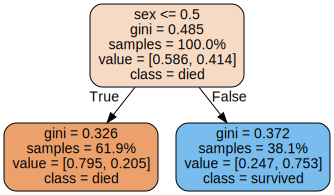

In [15]:
import graphviz

# Display decision tree
graphviz.Source(dot_data)

The graph encodes classes using colors. Nodes with a majority of samples labeled with "survived" appear in blue and nodes with a majority of samples labeled with "died" in orange. Each node contains the following information.

* gini - the impurity measure at this node
* samples - the percentage of samples in this node
* value - the probabilities for each class
* class - the class with the highest probability

The decision tree splits the data into two groups using a single rule on the sex of the passengers. **This feature is the most important one according to the Gini impurity measure.** Note that the node splits the samples by setting a threshold on the numerical label of the sex feature. Entries encoded with a zero (male) are in the left leaf and entries encoded with a one (female) are in the right leaf.

According to the samples entries in the image from above, there are respectively 61.9% and 38.1% of the samples in the left and right leaves. We can verify that using the value_counts() function from Pandas.

In [16]:
# Proportion of samples by sex
pd.value_counts(data_df.sex, normalize=True)

male      0.619048
female    0.380952
Name: sex, dtype: float64

The value entries in each leaf indicate the proportion of samples in each class. For instance, the left leaf has 79.5% of samples labeled with "died" and the remaining 20.5% labeled with "survived". Again, we can verify that using the crosstab() function from Pandas.

In [17]:
# Cross tabulation of sex and survived
crosstab = pd.crosstab(
    index=data_df.sex,
    columns=data_df.survived,
    normalize='index' # Normalize by sex
)
crosstab

survived,0,1
sex,,
female,0.246528,0.753472
male,0.794872,0.205128


The first row corresponds to the probabilities in the right leaf and the second row to the probabilities in the left one. Finally, let's use these probabilities to verify the Gini impurity values at each leaf

In [18]:
# Get p(survived) at each leaf
p_left = crosstab.loc['male', 1]
p_right = crosstab.loc['female', 1]

# Compute Gini impurity values
i_left = 2*p_left*(1-p_left)
i_right = 2*p_right*(1-p_right)
print('Gini impurity (left leaf): {:.3f}'.format(i_left))
# Prints: 0.326
print('Gini impurity (right leaf): {:.3f}'.format(i_right))
# Prints: 0.372

Gini impurity (left leaf): 0.326
Gini impurity (right leaf): 0.372


### Deeper trees
Let's try to increase the depth of the tree to two with the max_depth parameter.

In [19]:
# Create decision tree
dt_2 = DecisionTreeClassifier(
    criterion='gini', max_depth=2, random_state=0)

# Fit decision tree
dt_2.fit(X, y)

# Get score
dt_2.score(X, y)

0.8108465608465608

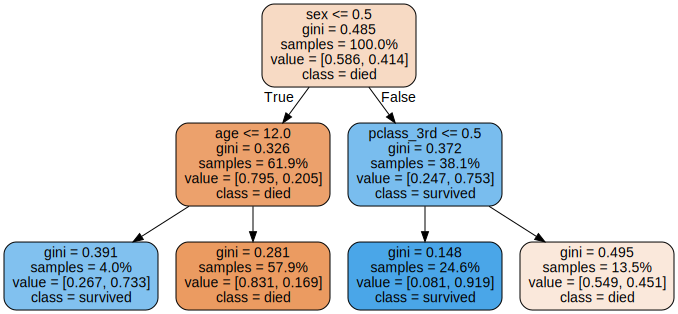

In [20]:
# Export decision tree
dot_data_2 = export_graphviz(
    dt_2, out_file=None,
    feature_names=features.columns, class_names=['died', 'survived'],
    filled=True, rounded=True, proportion=True   
)

# Display it
graphviz.Source(dot_data_2)

Again, one of the main advantages of the decision tree model is **its interpretability**. Here is a textual summary of the tree.

* Most men perished but young boys survived
* Most women survived, but half of the women from the 3rd class perished

However, the complexity of the tree increases with its depth, and it's easy to create a tree that overfits. For instance, let's remove the maximum depth criteria by setting it to None. This time, we will fit and evaluate the decision tree on different sets.

In [21]:
from sklearn.model_selection import train_test_split

# Split into train/test sets
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.3, random_state=0)

# Create decision tree
dt_max_depth = DecisionTreeClassifier(
    criterion='gini', max_depth=None, random_state=0)

# Fit decision tree
dt_max_depth.fit(X_tr, y_tr)

# Get train/test scores
print('Train accuracy: {:.3f}'.format(
    dt_max_depth.score(X_tr, y_tr)))
# Prints: 0.870

print('Test accuracy: {:.3f}'.format(
    dt_max_depth.score(X_te, y_te)))
# Prints: 0.784

Train accuracy: 0.870
Test accuracy: 0.784


As we can see, the decision tree correctly classifies 87% of the samples from the train set, but only 78.4% from the test set. **This is one of the main issues with decision trees. Small trees can be too simple (high bias) to model our data, and larger ones tend to overfit (high variance).**

### Summary

In this unit, we saw the basic idea behind decision trees and implemented one using Scikit-learn. Here are a few takeaways.

* Decision trees minimize an impurity measure at each split.
* The complexity of a decision tree depends on its depth.
* Scikit-learn DecisionTreeClassifier estimator requires categorical features to be encoded with one-hot encoding.

In practice, we use a decision tree when we want to build a **simple model that we can easily visualize and interpret**. However, we will see in the next unit that we can also combine **large trees into a random forest to create more complex models.**

### Question about multi class GINI
https://scikit-learn.org/stable/modules/tree.html
